# Joint RV & transit fits, TOI 1273

In [238]:
# Our tools
import exoplanet as xo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
from astropy.io import fits
from astropy.timeseries import BoxLeastSquares
from scipy import stats

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx

import os
import warnings
os.environ["MKL_THREADING_LAYER"] = "GNU"
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# plt.rcParams["figure.figsize"]=8,6
# plt.rcParams.update({'font.size': 16})

## Datasets and initializations
Lets start with the transits from TESS

In [239]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-dark-palette')

In [240]:
plt.rcParams["figure.figsize"]=8,6
plt.rcParams.update({'font.size': 16})

In [241]:
#sectors times, 15-22-23-48-50
from astropy.time import Time
sectors = ['2019-08-15T20:45:00','2019-09-10T22:00:00','2020-02-19T19:20:00','2020-03-18T00:00:00',
'2020-03-19T14:30:00','2020-04-15T09:10:00','2022-01-28T10:25:00','2022-02-25T11:50:00','2022-03-26T18:30:00','2022-04-22T00:25:00']
sectors_times = Time(sectors, format='fits')
sectors_times_btjd = sectors_times.jd-2457000
sectors_times_btjd

array([1711.36458333, 1737.41666667, 1899.30555556, 1926.5       ,
       1928.10416667, 1954.88194444, 2607.93402778, 2635.99305556,
       2665.27083333, 2691.51736111])

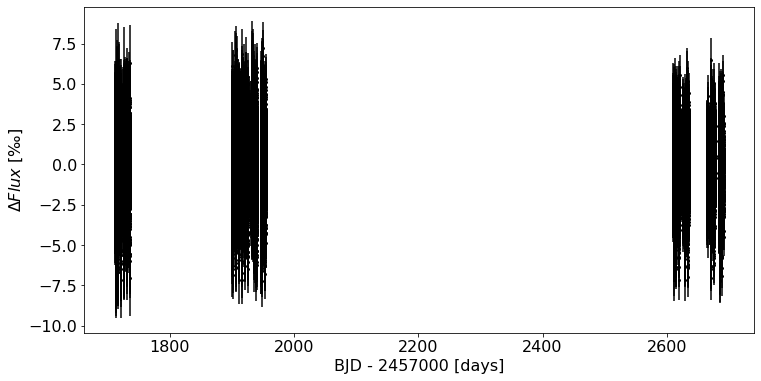

In [242]:
lc_file = lk.search_lightcurve('TIC 445859771', author='SPOC').download_all(flux_column="pdcsap_flux")
lc = lc_file.stitch().remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux

with fits.open(lc_file[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x_ = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y_ = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerr_ = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

plt.figure(figsize=(12, 6))
#plt.plot(time, y_, "o", color='black',markersize=2)
plt.errorbar(time, (flux-1.0)*1e3, yerr=lc.flux_err*1e3, color='k', fmt='o', ms=2)
#plt.plot(time, flux, '.k' )
plt.xlabel("BJD - 2457000 [days]")
plt.ylabel(u'$\Delta Flux$ [‰]')
#plt.xlim(1900,1901)
plt.show()
#plt.savefig('tessdata_1199.png',dpi=300,bbox_inches='tight')

In [243]:
lc.flux_err.std()*1e3

<Quantity 0.38137179>

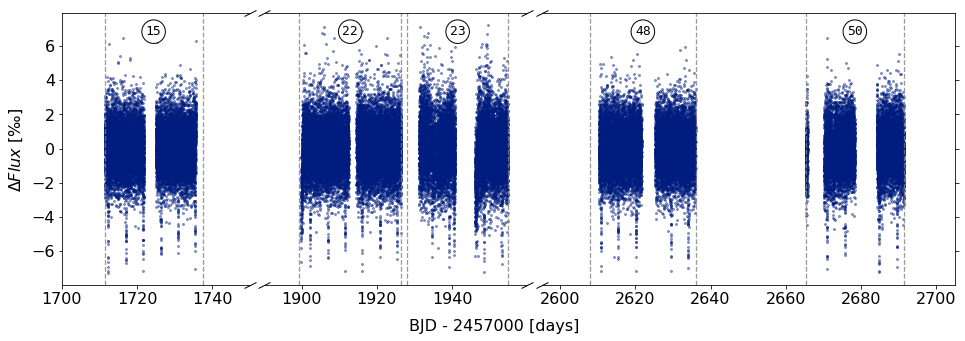

In [244]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16,5), gridspec_kw={'width_ratios': [1, 1.4, 2.2]})
fig.subplots_adjust(wspace=0.05)
ax1.plot(time, y_, "o", markersize=2, alpha=0.4)
ax2.plot(time, y_, "o", markersize=2, alpha=0.4)
ax3.plot(time, y_, "o", markersize=2, alpha=0.4)
off=15
ax1.set_xlim(1700, 1750)  
ax2.set_xlim(1890, 1960)  
ax3.set_xlim(2595, 2705)  
ax2.set_xticks([1900, 1920, 1940])
ax1.spines.right.set_visible(False)
ax2.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax3.spines.left.set_visible(False)
ax1.yaxis.tick_left()
#ax2.set_yticks([])
ax2.yaxis.tick_right()
ax3.yaxis.tick_right()
ax1.tick_params(labelright=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelright=False)
ax2.tick_params(labelleft=False)
ax3.tick_params(labelleft=False)

d = .5  
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)

ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)
ax2.plot([1, 1], [0, 1], transform=ax2.transAxes, **kwargs)
ax3.plot([0, 0], [1, 0], transform=ax3.transAxes, **kwargs)
for i in sectors_times_btjd[:2]:
    ax1.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
for i in sectors_times_btjd[2:6]:
    ax2.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
for i in sectors_times_btjd[6:]:
    ax3.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
ax1.text(sectors_times_btjd[0]+(sectors_times_btjd[1]-sectors_times_btjd[0])/2, 6.85, 
    "15", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.3", fc='white', lw=1))
ax2.text(sectors_times_btjd[2]+(sectors_times_btjd[3]-sectors_times_btjd[2])/2, 6.85, 
    "22", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.3", fc='white', lw=1))
ax2.text(sectors_times_btjd[4]+(sectors_times_btjd[5]-sectors_times_btjd[4])/2, 6.85, 
    "23", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.3", fc='white', lw=1))
ax3.text(sectors_times_btjd[6]+(sectors_times_btjd[7]-sectors_times_btjd[6])/2, 6.85, 
    "48", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.3", fc='white', lw=1))
ax3.text(sectors_times_btjd[8]+(sectors_times_btjd[9]-sectors_times_btjd[8])/2, 6.85, 
    "50", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.3", fc='white', lw=1))

fig.text(0.5, 0.01, "BJD - 2457000 [days]", ha='center', va='center')
fig.text(0.085, 0.5, u'$\Delta Flux$ [‰]', ha='center', va='center', rotation='vertical')
#plt.savefig('tessdata_1273.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

In [245]:
period_grid = np.exp(np.linspace(np.log(2), np.log(8), 50000)) #2 y 8 ---- 1 y 30
durations = np.exp(np.linspace(np.log(0.01), np.log(0.2), 100)) #0.01 y 0.2 

bls = BoxLeastSquares(x_, y_, yerr_)
bls_power = bls.power(period_grid, durations, oversample=30)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
bls_duration = bls_power.duration[index]

print('bls period:',bls_period)
print('bls t0:',bls_t0)
print('bls depth:',bls_depth)
print('ref_time:', ref_time)
print('epoch:', bls_t0 + ref_time)
print('bls duration:', bls_duration)

bls period: 4.631322521004829
bls t0: -489.09327633581546
bls depth: 3.8866713935873163
ref_time: 2201.436872421974
epoch: 1712.3435960861584
bls duration: 0.0496666666666667


In [246]:
# 1 y 30 grid
# bls period: 4.631191916352005
# bls t0: -489.0772763358155
# bls depth: 3.6220594837807694
# ref_time: 2201.436872421974
# epoch: 1712.3595960861585
# bls duration: 0.04833333333333336

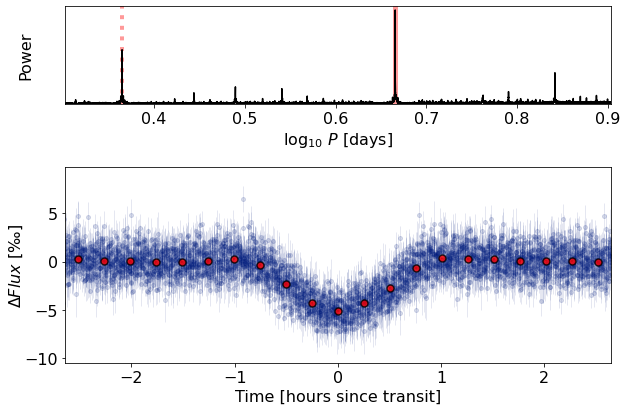

In [247]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), gridspec_kw={'height_ratios': [1, 2]})
fig.subplots_adjust(hspace=0.35)

ax1.axvline(np.log10(bls_period), color="red", lw=5, alpha=0.4)
ax1.axvline(np.log10(bls_period/2), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period/3), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period/4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*2), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*3), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.plot(np.log10(bls_power.period), bls_power.power, "k")
ax1.set_ylim(0,3000)
ax1.set_ylabel("Power", labelpad=32)
ax1.set_yticks([])
ax1.set_xlim(np.log10(period_grid.min())+0.001, np.log10(period_grid.max()))
ax1.set_xlabel(r"$\log_{10}~ P$ [days]")

# Plot the folded transit
x_fold_ = (x_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold_) < 0.4
ax2.plot(x_fold_*24, y_, ".", alpha=0.15, ms=8)
ax2.errorbar(x_fold_*24, y_, yerr=yerr_, fmt="none", elinewidth=1, alpha=0.1, capsize=0)

# Overplot the phase binned light curve
bins = np.linspace(-0.11, 0.11, 22)
denom, _ = np.histogram(x_fold_, bins)
num, _ = np.histogram(x_fold_, bins, weights=y_)
denom[num == 0] = 1.0
binned = stats.binned_statistic(x_fold_, y_, statistic='std', bins=bins)
binned_count = stats.binned_statistic(x_fold_, y_, statistic='count', bins=bins)
ax2.errorbar((0.5 * (bins[1:] + bins[:-1]))*24, num / denom, yerr=binned.statistic/np.sqrt(binned_count.statistic), fmt='o', color='k', 
                ms=7, markeredgecolor='k', markerfacecolor='red', markeredgewidth=1.5, alpha=0.8)

ax2.set_xlim(-0.11*24, 0.11*24)
ax2.set_ylabel(u'$\Delta Flux$ [‰]', labelpad=0)
_ = ax2.set_xlabel("Time [hours since transit]")
plt.tight_layout()

#plt.savefig('bls_paper_1273.png',dpi=300,bbox_inches='tight', facecolor='white')

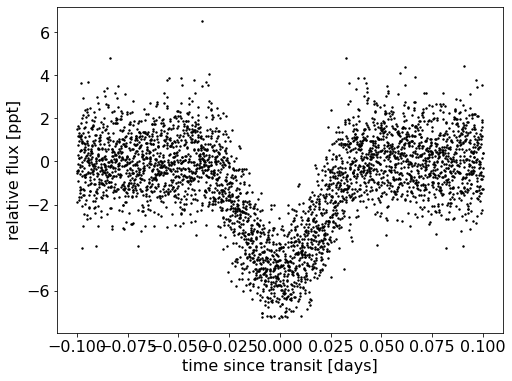

In [248]:
transit_mask = bls.transit_mask(x_, bls_period, 0.2, bls_t0)
x_fold_ = (x_ - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period

# Me quedo solo con los puntos cerca de los transitos
x_fold = x_fold_[transit_mask]
x = x_[transit_mask]
y = y_[transit_mask]
yerr = yerr_[transit_mask]

plt.scatter(x_fold, y, c='k', s=2)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]");
#plt.xlim(-0.12,0.12)

Now the SOPHIE RVs.

46


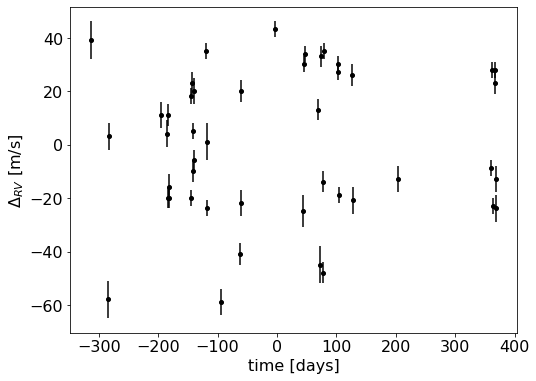

In [249]:
data = pd.read_table('1273_preliminary_rv_sophie.dat', sep='\s+')
data.rename(columns={'rv(km/s)': 'rv', 'sigRV(km/s)':'err'}, inplace=True)

x_rv = np.array(data.bjd-2457000)-ref_time
y_rv = np.array((data.rv-data.rv.mean())*1000)
yerr_rv = np.array(data.err*1000)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k", markersize=8)
plt.xlabel("time [days]")
print(len(x_rv))
_ = plt.ylabel("$\Delta_{RV}$ [m/s]")

Estimate the planet minimum mass and the semiamplitude.

In [250]:
import exoplanet as xo
import astropy.units as u

# Stellar parameters from Sousa
M_star = 0.98, 0.02
R_star = 1.07, 0.03

K = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0)
print('K=', K, "m/s")

msini = xo.estimate_minimum_mass(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0, m_star=M_star[0])
msini = msini.to(u.M_earth)
print('minimum mass=', msini)

K= [31.33745583] m/s
minimum mass= [80.59181539] earthMass


In [251]:
0.5*np.log(250 * 1e-3)

-0.6931471805599453

## Joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.

In [341]:
# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes 
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 3000)
phase_lc = np.linspace(-0.3, 0.3, 150)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:
        
        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0, sd=5)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_m_pl = pm.Normal("log_m_pl", mu=np.log(msini.value[0]), sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)

        #b = pm.Uniform("b", lower=0, upper=1.5)

        # # Or sample log_ror directly instead of depth, because b is really close to 1
        log_ror = pm.Normal("log_ror", mu=-2.90, sd=1)
        #log_ror = pm.TruncatedNormal("log_ror", mu=-2.64, sigma=1, upper=-1.9)
        #log_ror = pm.TruncatedNormal("log_ror", mu=-2.90, sigma=1, upper=-1)
        ror = pm.Deterministic("ror", tt.exp(log_ror))
        
        #ror = pm.LogNormal('ror', mu=-2.90, sigma=1)
        b = xo.ImpactParameter('b', ror)
        #b = pm.Uniform("b", lower=0, upper=1.2)
        
        r_pl = pm.Deterministic("r_pl", ror * r_star)

        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        period = pm.Deterministic("period", tt.exp(log_period))

        # comentar las proximas tres lineas para versión con e=0 fixed
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.01]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # RV jitter & a quadratic RV trend
        log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=1)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)  # [2,1,0]

        # Transit jitter
        logs = pm.Uniform("logs", lower=0, upper=1, testval=np.log(np.std(y)))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)* 1e3)
        light_curve = tt.sum(light_curves, axis=-1) + mean
        #resid = y[mask] - light_curve

        # The likelihood for the light curve
        pm.Normal("transit_obs", mu=light_curve, sd=tt.exp(logs), observed=y[mask])

        # Compute a reference time that will be used to normalize the trends model
        x_ref = 0.5 * (x_rv.min() + x_rv.max())
        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref, 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)


        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv**2 + tt.exp(2 * log_sigma_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        # Compute and save the phased light curve models
        pm.Deterministic("lc_pred",
            1e3 * star.get_light_curve(orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp)[..., 0],)

        # Fit for the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(start=start)
        map_soln = pmx.optimize(start=map_soln)

        extras = pmx.eval_in_model(light_curves, map_soln)

    return model, map_soln, extras

model0, map_soln0, extras0 = build_model()

optimizing logp for variables: [logs, trend, log_sigma_rv, b, log_ror, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -8842.583818003915 -> -6219.427224221218
optimizing logp for variables: [logs, trend, log_sigma_rv, b, log_ror, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -6219.427224221218 -> -6219.427224221168


Now let's plot the map radial velocity model.

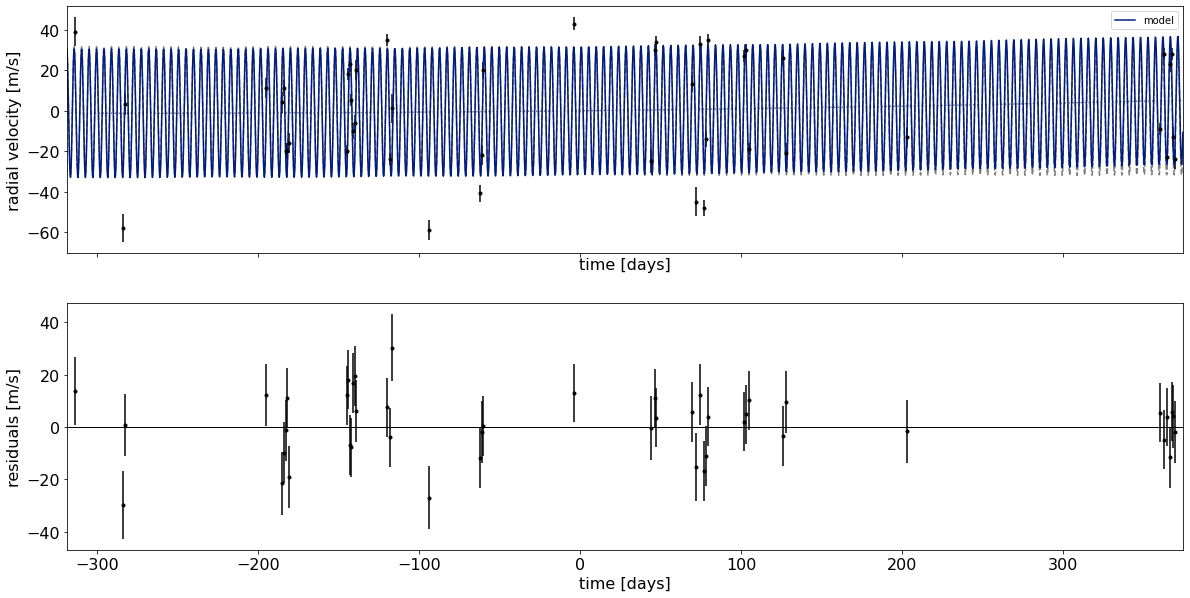

In [342]:
# We plot the initial model:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln['vrad_pred'], "--k", alpha=0.5)
    ax.plot(t_rv, soln['bkg_pred'], ":k", alpha=0.5)
    ax.plot(t_rv, soln['rv_model_pred'], label="model")
    ax.legend(fontsize=10)
    ax.set_xlabel("time [days]")
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2 + np.exp(2 * soln["log_sigma_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    #ax.set_xlim(2200,2300)
    ax.set_xlabel("time [days]")

_ = plot_rv_curve(map_soln0)

Now let's also plot the transit model.

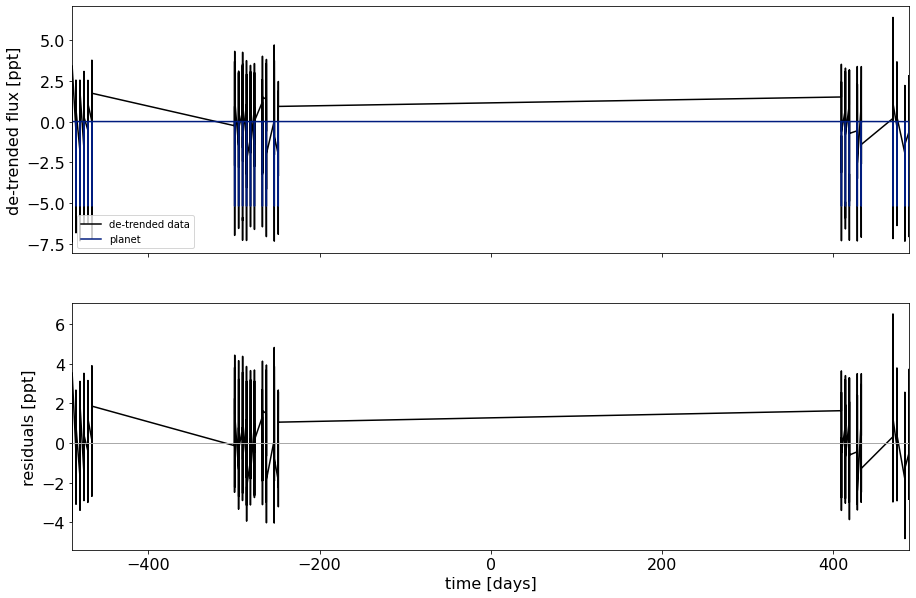

In [343]:
# We plot the initial light curve model:
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask] - soln['mean'], "k", label="de-trended data")
    mod = extras
    ax.plot(x[mask], mod, label="planet")
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[1]
    mod = np.sum(extras, axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    #plt.xlim(-93,-92)
    return fig


_ = plot_light_curve(map_soln0, extras0)

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the transit model and remove anything that is more than a 7-sigma outlier.

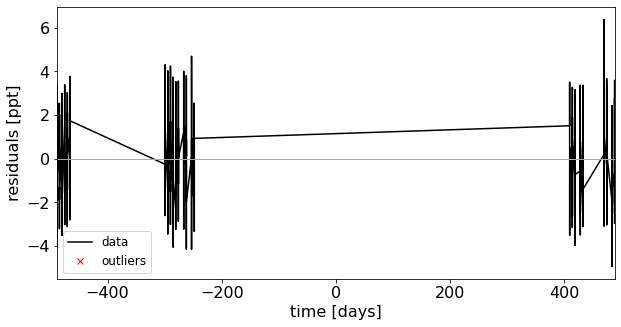

In [344]:
# We can do some sigma clipping to remove significant outliers.
mod = (map_soln0["mean"] + np.sum(extras0, axis=-1))

resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())
#plt.xlim(-450,-435)

Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: [logs, trend, log_sigma_rv, b, log_ror, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -6219.427224221168 -> -6219.427224221168
optimizing logp for variables: [logs, trend, log_sigma_rv, b, log_ror, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -6219.427224221168 -> -6219.427224221168


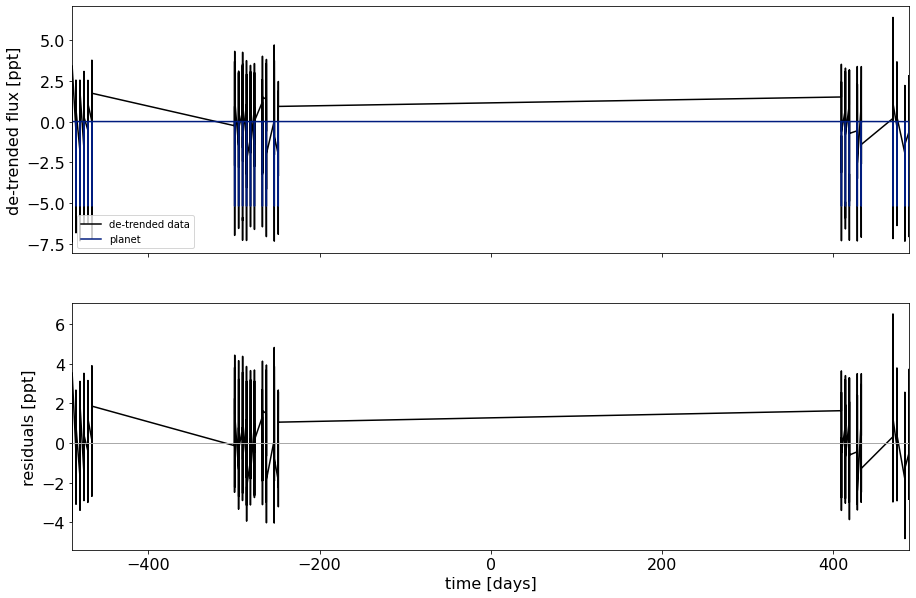

In [345]:
# looks like we don't have any outliers 
model, map_soln, extras = build_model(mask, map_soln0)
_ = plot_light_curve(map_soln, extras, mask)

Great! Now we're ready to sample.

## Sampling

In [346]:
import multiprocessing

with model:
    trace = pmx.sample(
        tune=4000, #2500,
        draws=4000, #2000,
        start=map_soln,
        cores=4, #4
        chains=2, #4
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[203771098, 203775000],#, 261136679, 261136680],
        init="adapt_full",
    )


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logs, trend, log_sigma_rv, b, log_ror, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 2899 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


In [347]:
import arviz as az
# version con e libre
#az.to_netcdf(trace, 'trace.toi1273.save')
trace = az.from_netcdf('trace.toi1273.save')

# version con e=0 fixed
# az.to_netcdf(trace, 'trace.toi1273_noecc.save')
#trace = az.from_netcdf('trace.toi1273_noecc.save')

'trace.toi1273_noecc.save'

Let's look at the convergence diagnostics for some of the key parameters:

In [348]:
import arviz as az

all_vars = ['logs','trend','log_sigma_rv','log_ror','b','log_period','log_m_pl','t0','r_star','m_star','u_star','mean','period',"r_pl","m_pl",'ror',"ecc","omega",'ecs']

az.summary(
    trace, stat_funcs={'median': np.median, 'std':np.std}, round_to=6,
    var_names=all_vars)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
logs,0.291810,0.011840,0.269022,0.313775,0.000125,0.000089,9120.417084,4202.985953,1.000316,0.291804,0.011839
trend[0],0.000015,0.000035,-0.000053,0.000079,0.000000,0.000000,9792.840986,5599.226412,0.999930,0.000015,0.000035
trend[1],0.009373,0.009721,-0.009110,0.027553,0.000103,0.000093,8830.010715,5821.306902,1.000107,0.009286,0.009721
trend[2],0.310794,0.913330,-1.399796,2.006801,0.009718,0.009750,8844.361508,5183.258708,1.000707,0.324406,0.913273
log_sigma_rv,2.429722,0.127867,2.193235,2.669850,0.001334,0.000948,9255.605224,6066.007783,1.000917,2.427579,0.127859
log_ror,-2.031391,0.356562,-2.478770,-1.368573,0.011208,0.007928,2356.778645,1017.193573,1.000886,-2.128277,0.356540
b,1.013273,0.095708,0.929395,1.134983,0.003955,0.002992,2433.064860,1050.050598,1.001024,0.988576,0.095702
log_period,1.532837,0.000001,1.532836,1.532838,0.000000,0.000000,10524.781525,3907.674345,1.000166,1.532837,0.000001
log_m_pl,4.400838,0.076458,4.257994,4.546654,0.000812,0.000574,9027.419549,5392.124633,0.999948,4.403354,0.076453
t0,-489.090158,0.000351,-489.090777,-489.089469,0.000004,0.000003,9714.668334,4520.146967,0.999997,-489.090159,0.000351


In [349]:
from uncertainties import ufloat
from uncertainties.umath import *

logsigma_rv_median = trace.posterior["log_sigma_rv"].median().item()
logsigma_rv = ufloat(logsigma_rv_median, trace.posterior["log_sigma_rv"].std().item())
rv_jitter_ = np.e**logsigma_rv
print('RV jitter =', rv_jitter_)

radio = (trace.posterior["r_pl"].median().item()*u.R_sun).to(u.R_jup).value
radio_err = (trace.posterior["r_pl"].std().item()*u.R_sun).to(u.R_jup).value
masa = (trace.posterior["m_pl"].median().item()*u.M_earth).to(u.M_jup).value
masa_err = (trace.posterior["m_pl"].std().item()*u.M_earth).to(u.M_jup).value
periodo = trace.posterior['period'].median().item()
periodo_sigma = trace.posterior['period'].std().item()
t_0 = trace.posterior['t0'].median().item()+ref_time
t_0_sigma = trace.posterior['t0'].std().item()
print("Radio = {r:.3f} \u00B1 {r_err:.3f} Rj".format(r=radio, r_err=radio_err))
print("Masa = {m:.3f} \u00B1 {m_err:.3f} Mj".format(m=masa, m_err=masa_err))
print("Periodo = {p:.6f} \u00B1 {p_s:.6f}".format(p=periodo, p_s=periodo_sigma))
print("Epoca = {e:.5f} \u00B1 {e_s:.4f}".format(e=t_0, e_s=t_0_sigma))

RV jitter = 11.3+/-1.4
Radio = 1.247 ± 0.920 Rj
Masa = 0.257 ± 0.020 Mj
Periodo = 4.631298 ± 0.000003
Epoca = 1712.34671 ± 0.0004


In [350]:
# Posterior constraints: rho>0.1 g/cc, log_ror<-1.9, ror<1.5
trace2 = trace.copy()
samps = trace2.posterior.stack(sample=("chain", "draw"))
index = samps['r_pl'] < 0.15
radio2 = (samps['r_pl'][index].median().item()*u.R_sun).to(u.R_jup).value
radio2_err = (samps['r_pl'][index].std().item()*u.R_sun).to(u.R_jup).value
masa2 = (samps['m_pl'][index].median().item()*u.M_earth).to(u.M_jup).value
masa2_err = (samps['m_pl'][index].std().item()*u.M_earth).to(u.M_jup).value
print("Radio2 = {r:.3f} \u00B1 {r_err:.3f} Rj".format(r=radio2, r_err=radio2_err))
print("Masa2 = {m:.3f} \u00B1 {m_err:.3f} Mj".format(m=masa2, m_err=masa2_err))

Radio2 = 1.146 ± 0.150 Rj
Masa2 = 0.257 ± 0.020 Mj


In [351]:
# Posterior constraints: rho>0.1 g/cc, log_ror<-1.9, ror<1.5
trace2 = trace.copy() # az.InferenceData
posterior = az.extract_dataset(trace2) # xarray.Dataset 
posterior_subset = posterior.where(posterior["r_pl"] < 0.15, drop=True) # xarray.Dataset
trace_subset = az.convert_to_inference_data(posterior_subset) # az.InferenceData

In [352]:
radio2 = (trace_subset.posterior["r_pl"].median().item()*u.R_sun).to(u.R_jup).value
radio2_err = (trace_subset.posterior["r_pl"].std().item()*u.R_sun).to(u.R_jup).value
masa2 = (trace_subset.posterior["m_pl"].median().item()*u.M_earth).to(u.M_jup).value
masa2_err = (trace_subset.posterior["m_pl"].std().item()*u.M_earth).to(u.M_jup).value
periodo2 = trace_subset.posterior['period'].median().item()
periodo2_sigma = trace_subset.posterior['period'].std().item()
t_02 = trace_subset.posterior['t0'].mean().item()+ref_time
t_02_sigma = trace_subset.posterior['t0'].std().item()
G = 6.6743e-11
teff = ufloat(5697,62)
smaxis = ((ufloat(periodo2*u.day.to(u.second),periodo2_sigma*u.day.to(u.second)))**2*G*(ufloat(trace_subset.posterior['m_star'].median().item()*u.M_sun.to(u.kg), trace_subset.posterior['m_star'].std().item()*u.M_sun.to(u.kg))+
            ufloat(masa2*u.M_jup.to(u.kg), masa2_err*u.M_jup.to(u.kg)))/(4*np.pi**2))**(1/3)*u.m.to(u.au)
teq = teff*(ufloat(trace_subset.posterior['r_star'].median().item()*u.R_sun.to(u.au), trace_subset.posterior['r_star'].std().item()*u.R_sun.to(u.au))/smaxis)**(1/2)*(1/4)**(1/4)
print("Radio2 = {r:.3f} \u00B1 {r_err:.3f} Rj".format(r=radio2, r_err=radio2_err))
print("Masa2 = {m:.3f} \u00B1 {m_err:.3f} Mj".format(m=masa2, m_err=masa2_err))
print("Periodo2 = {p:.6f} \u00B1 {p_s:.6f}".format(p=periodo2, p_s=periodo2_sigma))
print("Epoca = {e:.5f} \u00B1 {e_s:.4f}".format(e=t_02, e_s=t_02_sigma))
print('Semieje mayor= {s:.4f} au'.format(s=smaxis))
print('Temperatura de equilibrio= {t:.3f} K'.format(t=teq))

Radio2 = 1.146 ± 0.150 Rj
Masa2 = 0.257 ± 0.020 Mj
Periodo2 = 4.631298 ± 0.000003
Epoca = 1712.34672 ± 0.0003
Semieje mayor= 0.0540+/-0.0004 au
Temperatura de equilibrio= 1221.196+/-20.797 K


In [ ]:
# resultado con e libre
# Radio2 = 1.126 ± 0.149 Rj
# Masa2 = 0.257 ± 0.020 Mj
# Periodo2 = 4.631298 ± 0.000003
# Epoca = 1712.34663 ± 0.0004
# Semieje mayor= 0.0540+/-0.0004 au
# Temperatura de equilibrio= 1222.412+/-20.950 K

In [263]:
dim1_vars = ['logs', 'log_sigma_rv', 'log_ror', 'b', 'log_period', 'log_m_pl', 't0', 
            'r_star', 'm_star', 'mean', 'period', "r_pl", "m_pl", "ecc", "omega", 'ror'] # faltan 'u_star' (dim2), 'ecs' (dim2), 'trend' (dim3)
dict2 = {}
for i in dim1_vars:
        dict2[i] = samps[i][index].values
az.summary(
    dict2, stat_funcs={'median': np.median, 'std':np.std}, round_to=6,
    var_names=dim1_vars)

arviz - WARNING - Shape validation failed: input_shape: (1, 5617), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
logs,0.291888,0.011745,0.269795,0.313897,0.000147,0.000104,6354.458170,3882.318346,NaN,0.291784,0.011744
log_sigma_rv,2.430246,0.128325,2.178614,2.663234,0.001683,0.001193,5821.529449,4209.637765,NaN,2.431220,0.128314
log_ror,-2.217110,0.125607,-2.429175,-1.987647,0.001692,0.001198,5449.126261,4777.888248,NaN,-2.220094,0.125596
b,0.973149,0.022911,0.931186,1.015809,0.000368,0.000261,3897.989000,4180.777557,NaN,0.973018,0.022908
log_period,1.532837,0.000001,1.532836,1.532838,0.000000,0.000000,6869.357297,4147.512691,NaN,1.532837,0.000001
log_m_pl,4.400094,0.078354,4.256898,4.547714,0.000977,0.000691,6604.904303,3426.691348,NaN,4.404300,0.078347
t0,-489.090246,0.000396,-489.090983,-489.089501,0.000005,0.000003,6522.080801,4114.296718,NaN,-489.090239,0.000396
r_star,1.069235,0.027387,1.017890,1.120363,0.000367,0.000259,5592.784730,3866.844659,NaN,1.069563,0.027385
m_star,0.980010,0.019859,0.942154,1.016284,0.000253,0.000179,6138.462692,4286.463810,NaN,0.980106,0.019857
mean,0.118774,0.027400,0.067706,0.170559,0.000334,0.000244,6735.935086,4305.986438,NaN,0.118989,0.027398


In [264]:
var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega']
dict1 = {}
for i in var_names:
        dict1[i] = samps[i][index].values

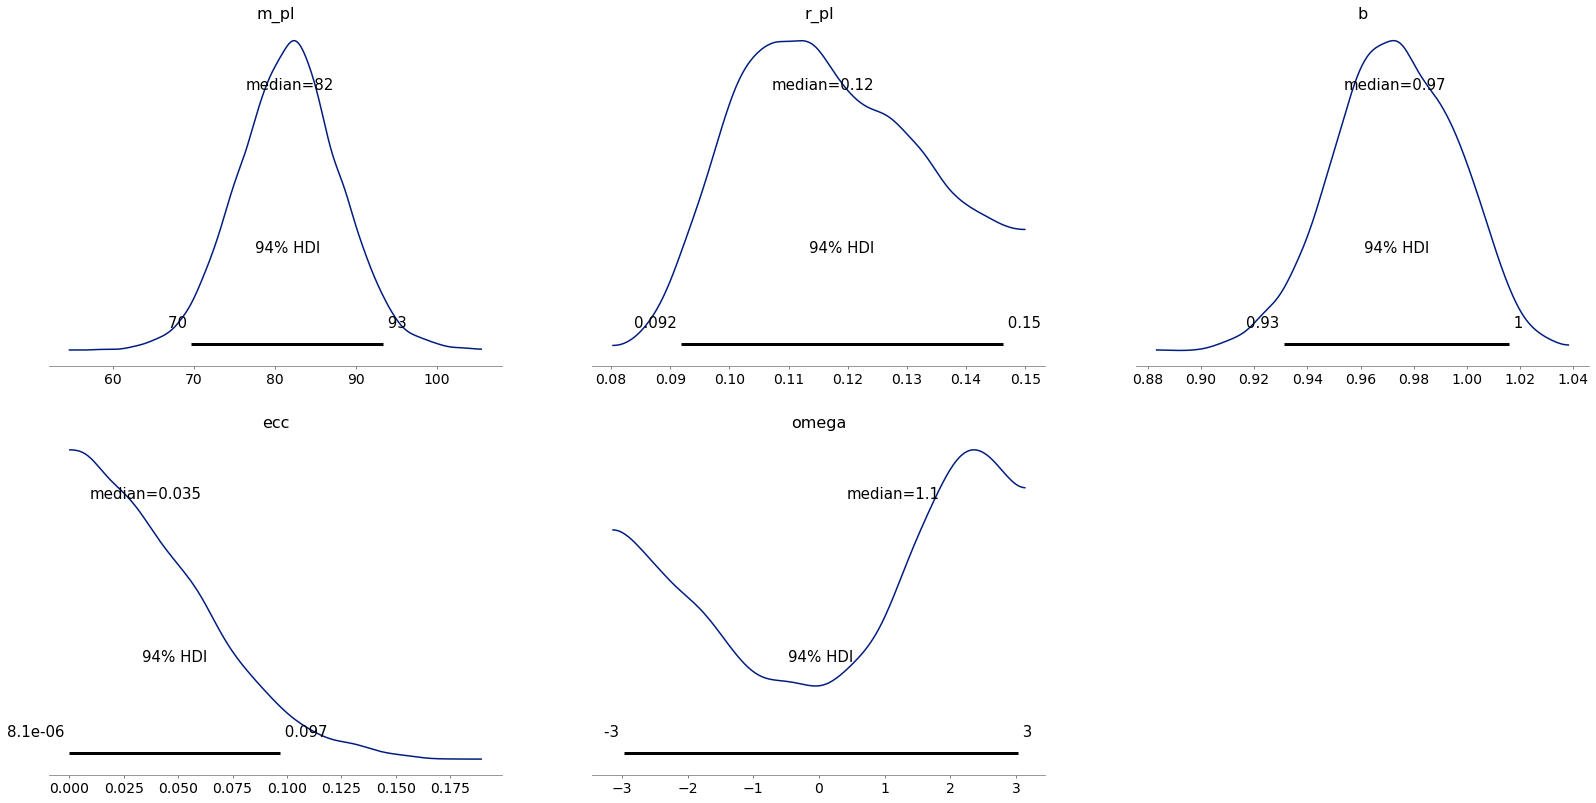

In [265]:
az.plot_posterior(posterior_subset, var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega'], 
                    combine_dims={"sample"}, point_estimate='median')

plt.show()

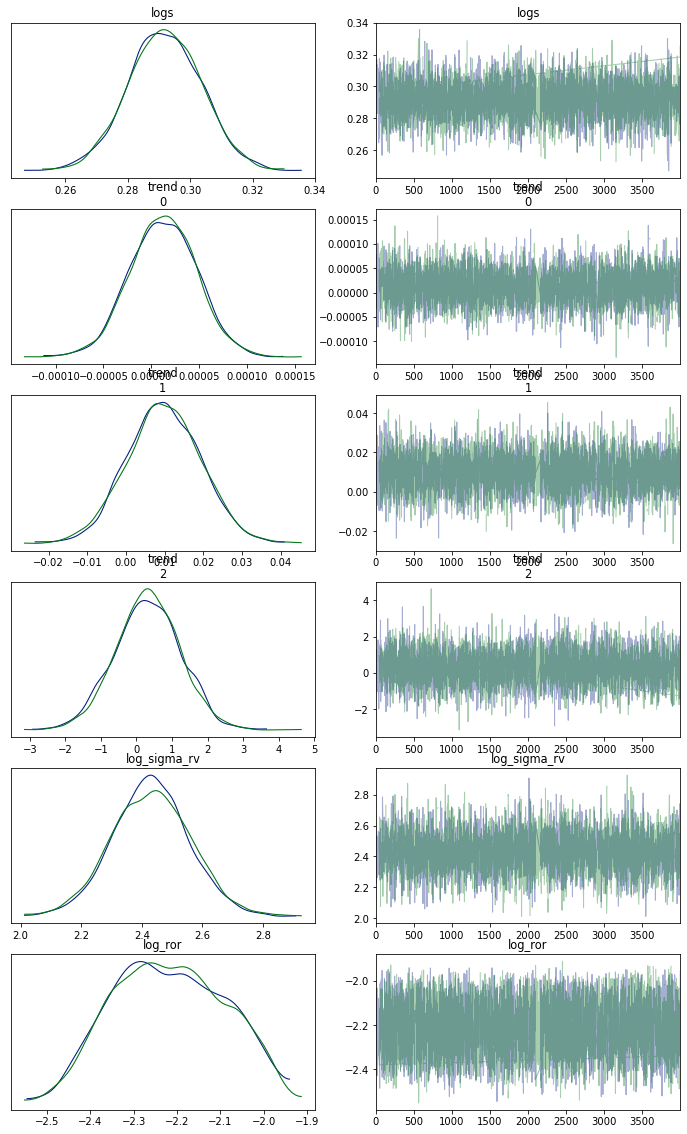

In [266]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag


_ = az.plot_trace(trace_subset.unstack(), var_names=['logs', 'trend','log_sigma_rv', 'log_ror'] # trace or trace_subset.stack()
                                    , compact=False, figsize=(12,20)) 
# plt.savefig('trace_joint_1273_reparam_3.png',dpi=200,bbox_inches='tight')

In [267]:
dict1['r_pl'] = dict1['r_pl']*9.73116

In [268]:
CORNER_KWARGS = dict(
    smooth=0.9,
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    levels=(0.16,0.5,0.84),
    max_n_ticks=3
)

<Figure size 1008x1008 with 0 Axes>

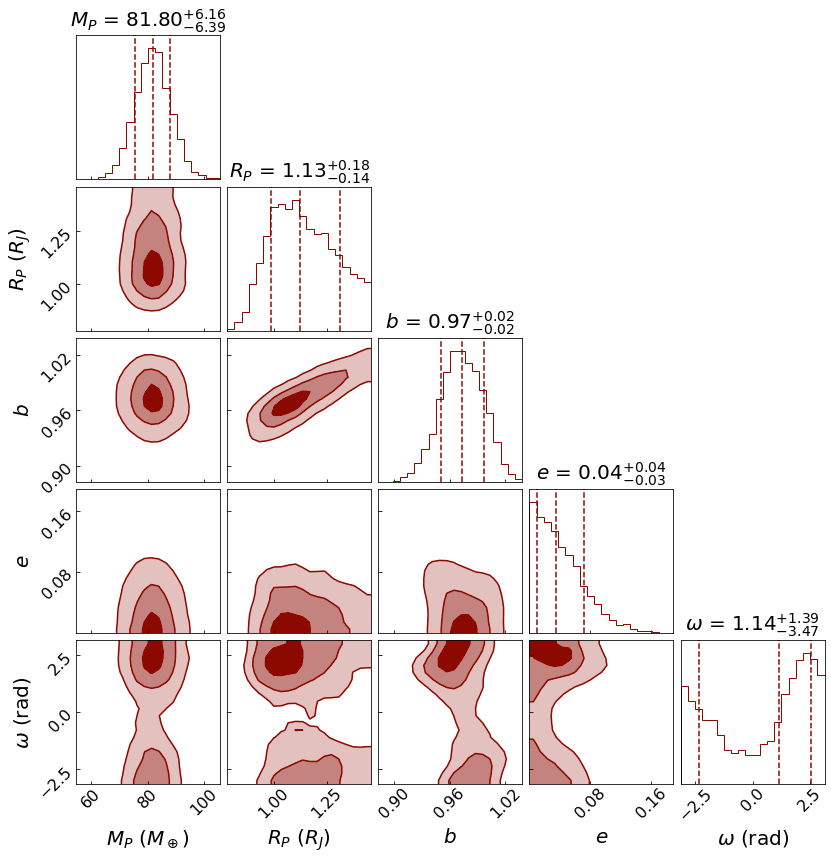

In [340]:
from cProfile import label
import corner

plt.figure(figsize=(14,14))
figure = corner.corner(dict1, var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega'],#, 'omega'], 
                        labels=[r"$M_P ~(M_\oplus)$", r"$R_P ~(R_{J})$", r"$b$", r"$e$", r"$\omega$ (rad)"], label_kwargs={'fontsize':20},#, r"$\omega$ (rad)"],
                        show_titles=True, title_kwargs={'fontsize':20, 'pad':9.0}, titles=['$M_P$','$R_P$','$b$','$e$', '$\omega$'], divergences=True, plot_contours=True,
                        labelpad=0, color='C2', quantiles=[0.16, 0.5, 0.84], **CORNER_KWARGS) #, quantiles=[0.16, 0.5, 0.84],
for ax in figure.get_axes():
    ax.tick_params(axis='both', pad=1, direction='in', labelbottom=True, labelleft=True, left=True, bottom=True)
#plt.savefig('corner_1273.png',dpi=300,bbox_inches='tight')
plt.show()

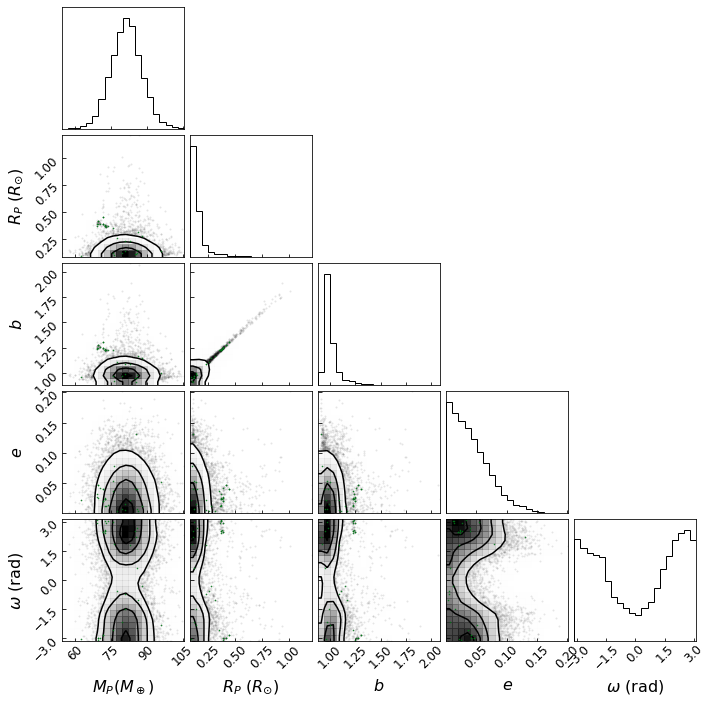

In [270]:
import corner

figure = corner.corner(trace2, var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega'], 
                        labels=[r"$M_P (M_\oplus)$", r"$R_P ~(R_{\odot})$", r"$b$", r"$e$", r"$\omega$ (rad)"],
                        show_titles=False, title_kwargs={'fontsize':10}, divergences=True, plot_contours=True,
                        smooth=True) 
#figure.subplots_adjust(right=1, top=1)
figure.set_size_inches(10,10)
for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=12, pad=1, direction='in')

#plt.savefig('corner_paper_1273.png',dpi=200,bbox_inches='tight')

## Phase plots

In [271]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Get the posterior median orbital parameters
# p_ = np.median(flat_samps["period"])
# t0_ = np.median(flat_samps["t0"])
# mean = np.median(flat_samps["mean"])

p_ = trace_subset.posterior['period'].median().item()
t0_ = trace_subset.posterior['t0'].median().item()
mean = trace_subset.posterior['mean'].median().item()

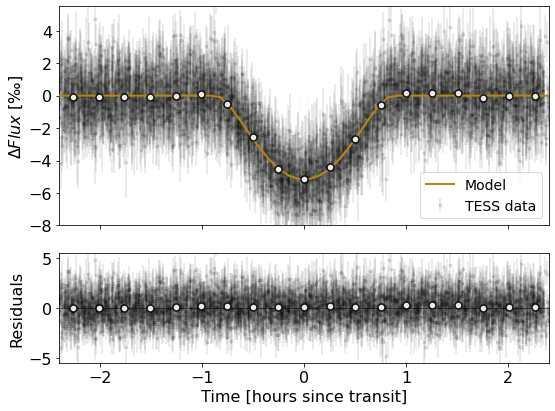

In [309]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [2,1]})
# Plot the folded data
x_fold2 = (x[mask] - t0_ + 0.5 * p_) % p_ - 0.5 * p_
#ax1.plot(x_fold2*24, y[mask] - mean, ".k", label="TESS data", zorder=-1000, alpha=0.15)
ax1.errorbar(x_fold2*24, y[mask] - mean, yerr=yerr[mask], fmt=".k", label="TESS data", capsize=0, zorder=-1000, alpha=0.1)
# Overplot the phase binned light curve
bins = np.linspace(-0.11, 0.11, 22)
denom, _ = np.histogram(x_fold2, bins)
num, _ = np.histogram(x_fold2, bins, weights=y[mask] - mean)
denom[num == 0] = 1.0
binned = stats.binned_statistic(x_fold2, y[mask] - mean, statistic='std', bins=bins)
binned_count = stats.binned_statistic(x_fold2, y[mask] - mean, statistic='count', bins=bins)
ax1.errorbar((0.5 * (bins[1:] + bins[:-1]))*24, num / denom, yerr=binned.statistic/np.sqrt(binned_count.statistic), fmt='o', color='k', 
                ms=7, markeredgecolor='k', markerfacecolor='white', markeredgewidth=1.5, alpha=0.9, zorder=900)

#pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
pred = np.percentile(trace_subset.posterior['lc_pred'], [16, 50, 84], axis=-1)
ax1.plot(phase_lc*24, pred[1], color="C4", label="Model", zorder=800, linewidth=2)
art = ax1.fill_between(phase_lc, pred[0], pred[2], color="C4", alpha=0.5, zorder=800)
art.set_edgecolor("none")

ax1.legend(fontsize=14, loc=4)
ax1.set_ylabel(u'$\Delta Flux$ [‰]')
ax1.set_xlim(-0.10*24, 0.10*24)
ax1.set_ylim(-8,5.5)
ax1.set_yticks([-8, -6,-4,-2,0,2,4])

ax2.axhline(y=0, color='k', linewidth=1, alpha=0.5)
#ax2.plot(x_fold2*24, y[mask] - np.sum(extras, axis=-1), ".k", label="data", zorder=-1000, alpha=0.15)
ax2.errorbar(x_fold2*24, y[mask] - np.sum(extras, axis=-1), yerr=yerr[mask], label="data", fmt=".k", capsize=0, zorder=-1000, alpha=0.1)
# Overplot the phase binned residuals
num, _ = np.histogram(x_fold2, bins, weights=y[mask] - np.sum(extras, axis=-1))
denom[num == 0] = 1.0
binned = stats.binned_statistic(x_fold2, y[mask] - np.sum(extras, axis=-1), statistic='std', bins=bins)
binned_count = stats.binned_statistic(x_fold2, y[mask] - np.sum(extras, axis=-1), statistic='count', bins=bins)
ax2.errorbar((0.5 * (bins[1:] + bins[:-1]))*24, num / denom, yerr=binned.statistic/np.sqrt(binned_count.statistic), fmt='o', color='k', 
                ms=7, markeredgecolor='k', markerfacecolor='white', markeredgewidth=1.5, alpha=0.9, zorder=900)
ax2.set_ylabel('Residuals')
ax2.set_xlabel("Time [hours since transit]")
ax2.set_ylim(-5.5,5.5)
plt.tight_layout()
#plt.savefig('fit_transit_joint_1273.png',dpi=300,bbox_inches='tight', facecolor='white')

In [273]:
# rv_jitter = np.exp(np.median(flat_samps['log_sigma_rv']))
# bkg_ = np.median(flat_samps['bkg'].values, axis=-1)
# rv_model_ = np.median(flat_samps['rv_model'].values, axis=-1)

rv_jitter = np.exp(trace_subset.posterior['log_sigma_rv'].median().item())
bkg_ = np.median(trace_subset.posterior['bkg'].values, axis=-1)
rv_model_ = np.median(trace_subset.posterior['rv_model'].values, axis=-1)

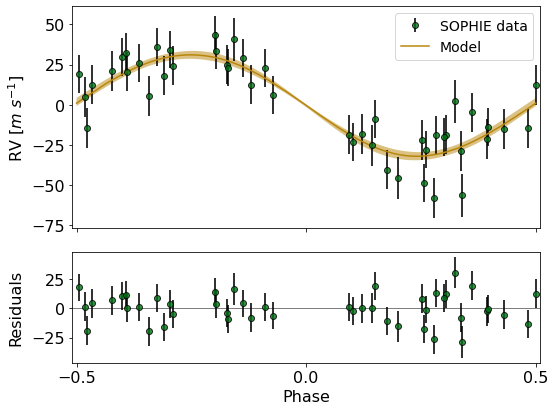

In [274]:
# Plot the folded data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [2,1]})
x_fold = (x_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
ax1.errorbar(x_fold/p_, y_rv - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='C1', 
            markeredgecolor='k', ecolor='k', elinewidth=2, label='SOPHIE data', alpha=0.8)
#ax1.set_ylim(-70,70)

# Compute the posterior prediction for the folded RV model 
t_fold = (t_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
inds = np.argsort(t_fold)
#pred = np.percentile(trace.posterior["vrad_pred"].values[:, :, inds],[16, 50, 84],axis=(0, 1),)
pred = np.percentile(trace_subset.posterior['vrad_pred'][inds],[16, 50, 84], axis=-1)
ax1.plot(t_fold[inds]/p_, pred[1], color="C4", label="Model")
art = ax1.fill_between(t_fold[inds]/p_, pred[0], pred[2], color="C4", alpha=0.5)
art.set_edgecolor("none")
#ax1.set_xlim(-0.5 * p_, 0.5 * p_)
ax1.set_xlim(-0.51, 0.51)
ax1.set_ylabel("RV [$m~s^{-1}$]")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],fontsize=14, loc='best')

# Plot the folded residuals
ax2.axhline(y=0, color='k', linewidth=1, alpha=0.5)
ax2.errorbar(x_fold/p_, y_rv-rv_model_ - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='C1',
            markeredgecolor='k', ecolor='k', elinewidth=2, alpha=0.8, label='residuals')
ax2.set_ylabel('Residuals', labelpad=8)
ax2.set_xlabel("Phase")
ax2.set_xlim(-0.51, 0.51)
ax2.set_xticks([-0.5, 0, 0.5])
plt.tight_layout()
#plt.savefig('fit_rv_joint_1273.png',dpi=300,bbox_inches='tight', facecolor='white')

In [275]:
from uncertainties import ufloat
from uncertainties.umath import *

rpl = ufloat((radio *u.R_jup).to(u.cm).value, (radio_err *u.R_jup).to(u.cm).value)  
mpl = ufloat((masa *u.M_jup).to(u.g).value, (masa_err *u.M_jup).to(u.g).value)

rpl2 = ufloat((radio2 *u.R_jup).to(u.cm).value, (radio2_err *u.R_jup).to(u.cm).value)  
mpl2 = ufloat((masa2 *u.M_jup).to(u.g).value, (masa2_err *u.M_jup).to(u.g).value)

densidad1 = mpl * 1/(4 / 3 * np.pi * rpl**3)
densidad2 = mpl2 * 1/(4 / 3 * np.pi * rpl2**3)

print('densidad1', densidad1)
print('densidad2', densidad2)

densidad1 0.17+/-0.33
densidad2 0.22+/-0.09


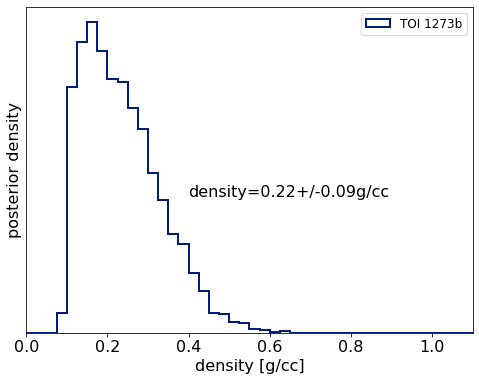

In [276]:
volume = 4 / 3 * np.pi * trace_subset.posterior['r_pl'] ** 3
density = u.Quantity(trace_subset.posterior['m_pl'] / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
plt.hist(
        density,
        bins,
        histtype="step",
        lw=2,
        label='TOI 1273b',
        density=True,)
plt.yticks([])
plt.text(0.4, 2, 'density={:.2f}+/-{:.2f}g/cc'.format(np.median(density),np.std(density)))
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
_ = plt.ylabel("posterior density")
#plt.savefig('density_joint_1273_reparam.png',dpi=200,bbox_inches='tight')

We can also compute the posterior constraints on the planet densitiy.

### New Photometry

In [360]:
# all have the same columns
data1 = pd.read_table('/home/juan/Documents/PAPER_TESS/data/photom/TOI1273/TIC445859771.01_UT2020.0213_KeplerCam_B.txt', sep='\s+')
data2 = pd.read_table('/home/juan/Documents/PAPER_TESS/data/photom/TOI1273/TOI1273-01_20200218_g_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
data3 = pd.read_table('/home/juan/Documents/PAPER_TESS/data/photom/TOI1273/TOI1273-01_20200218_i_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
data4 = pd.read_table('/home/juan/Documents/PAPER_TESS/data/photom/TOI1273/TOI1273-01_20200218_r_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
data5 = pd.read_table('/home/juan/Documents/PAPER_TESS/data/photom/TOI1273/TOI1273-01_20200218_zs_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')

In [361]:
#puntos?
print('puntos:', len(data1)+len(data2)+len(data3)+len(data4)+len(data5))

puntos: 7220


In [364]:
data1['flux'] = ((data1['rel_flux_T1']/(data1['rel_flux_T1'].median())))*1e3
data2['flux'] = (data2['flux'])*1e3
data3['flux'] = (data3['flux'])*1e3
data4['flux'] = (data4['flux'])*1e3
data5['flux'] = (data5['flux'])*1e3
data1['time'] = data1['BJD_TDB']-2457000-ref_time
data2['time'] = data2['BJD_TDB']-2457000-ref_time
data3['time'] = data3['BJD_TDB']-2457000-ref_time
data4['time'] = data4['BJD_TDB']-2457000-ref_time
data5['time'] = data5['BJD_TDB']-2457000-ref_time

data1['flux_err'] = ((data1['rel_flux_err_T1']/(data1['rel_flux_T1'].median())))*1e3
data2['flux_err'] = (data2['flux_err'])*1e3
data3['flux_err'] = (data3['flux_err'])*1e3
data4['flux_err'] = (data4['flux_err'])*1e3
data5['flux_err'] = (data5['flux_err'])*1e3

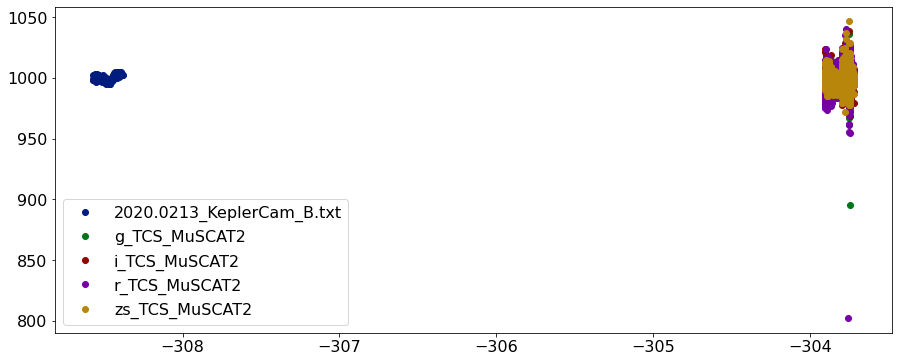

In [365]:
plt.figure(figsize=(15,6))
plt.plot(data1['time'], data1['flux'], 'o', label='2020.0213_KeplerCam_B.txt')
plt.plot(data2['time'], data2['flux'], 'o', label='g_TCS_MuSCAT2')
plt.plot(data3['time'], data3['flux'], 'o', label='i_TCS_MuSCAT2')
plt.plot(data4['time'], data4['flux'], 'o', label='r_TCS_MuSCAT2')
plt.plot(data5['time'], data5['flux'], 'o', label='zs_TCS_MuSCAT2')
plt.legend(loc='best')

In [366]:
#foldeo todos los datos
data1_fold = (data1['time'] - t0_ + 0.5 * p_) % p_ - 0.5 * p_
data2_fold = (data2['time'] - t0_ + 0.5 * p_) % p_ - 0.5 * p_
data3_fold = (data3['time'] - t0_ + 0.5 * p_) % p_ - 0.5 * p_
data4_fold = (data4['time'] - t0_ + 0.5 * p_) % p_ - 0.5 * p_
data5_fold = (data5['time'] - t0_ + 0.5 * p_) % p_ - 0.5 * p_

In [368]:
#saquemos los outliers de MUSCAT data afuera de 3-sigma
sigmas = 3
x_conc = np.concatenate((data2_fold*24, data3_fold*24
                        ,data4_fold*24, data5_fold*24), axis=None)
y_conc = np.concatenate((data2['flux'], data3['flux']
                        ,data4['flux'], data5['flux']), axis=None)
yerr_conc = np.concatenate((data2['flux_err'], data3['flux_err']
                        ,data4['flux_err'], data5['flux_err']), axis=None)
                        
index3 = (y_conc >= np.mean(y_conc)-sigmas*np.std(y_conc)) & (y_conc <= np.mean(y_conc)+sigmas*np.std(y_conc))

In [369]:
def msk(x):
    mk = (x >= np.mean(y_conc)-sigmas*np.std(y_conc)) & (x <= np.mean(y_conc)+sigmas*np.std(y_conc))
    return mk
x_conc1 = x_conc[msk(y_conc)]
y_conc1 = y_conc[msk(y_conc)]
yerr_conc1 = yerr_conc[msk(y_conc)]

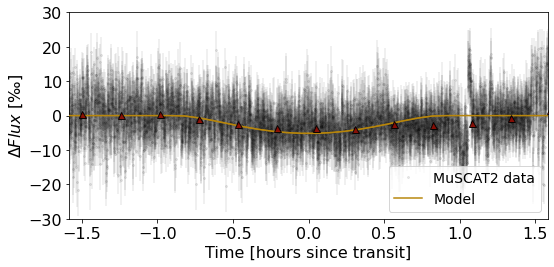

In [387]:
from scipy import stats
# Plot the folded data
plt.figure(figsize=(8,4))
plt.plot(x_conc1, y_conc1 - 1e3, '.', color='k', ms=4, label='MuSCAT2 data', zorder=-1000, alpha=0.08)
plt.errorbar(x_conc1, y_conc1 - 1e3, yerr=yerr_conc1, fmt='none', color='k', alpha=0.08, zorder=-1000)
# Plot the model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc*24, pred[1], color="C4", label="Model", zorder=900)
plt.fill_between(phase_lc*24, pred[0], pred[2], color="C4", alpha=0.5)
# Plot the binned lightcurve
bins = np.linspace(-0.068*24, 0.0720*24, 14)
#bins = np.linspace(-0.11*24, 0.11*24, 22)
denom, _ = np.histogram(x_conc1, bins)
num, _ = np.histogram(x_conc1, bins, weights=y_conc1-1e3)
denom[num == 0] = 1.0
binned = stats.binned_statistic(x_conc1, y_conc1, statistic='std', bins=bins)
binned_count = stats.binned_statistic(x_conc1, y_conc1, statistic='count', bins=bins)
plt.errorbar((0.5 * (bins[1:] + bins[:-1])), num / denom, yerr=binned.statistic/np.sqrt(binned_count[0]), fmt='^', color='k', 
         ms=7, markeredgecolor='k',markerfacecolor='C2', markeredgewidth=1, alpha=0.9, zorder=1000)
#plt.legend(fontsize=14, loc='best')
plt.legend(fontsize=14, loc=4)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time [hours since transit]")
plt.xlim(-0.066*24, 0.066*24)
#plt.xlim(-0.10*24, 0.10*24)
plt.ylim(-30, 30)
plt.tight_layout()
#plt.savefig('new_phot_1273_muscat2.png', dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

In [371]:
oot_mask2 = bls.transit_mask(data2['time'], p_, bls_duration, t0_)
oot_mask3 = bls.transit_mask(data3['time'], p_, bls_duration, t0_)
oot_mask4 = bls.transit_mask(data4['time'], p_, bls_duration, t0_)
oot_mask5 = bls.transit_mask(data5['time'], p_, bls_duration, t0_)

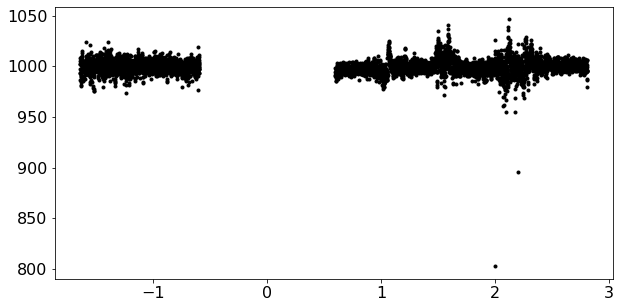

In [372]:
# checking the oot mask
plt.figure(figsize=(10, 5))
plt.plot((data2_fold*24)[~oot_mask2], data2['flux'][~oot_mask2] - mean, ".k")
plt.plot((data3_fold*24)[~oot_mask3], data3['flux'][~oot_mask3] - mean, ".k")
plt.plot((data4_fold*24)[~oot_mask4], data4['flux'][~oot_mask4] - mean, ".k")
plt.plot((data5_fold*24)[~oot_mask5], data5['flux'][~oot_mask5] - mean, ".k")

In [373]:
# fitemos un pol grado 2 a los datos oot
x_oot = np.concatenate(((data2_fold*24)[~oot_mask2], (data3_fold*24)[~oot_mask3], (data4_fold*24)[~oot_mask4]
                        ,(data5_fold*24)[~oot_mask5] ), axis=None)
y_oot = np.concatenate((data2['flux'][~oot_mask2], data3['flux'][~oot_mask3], data4['flux'][~oot_mask4]
                        ,data5['flux'][~oot_mask5] ), axis=None)
z = np.polyfit(x_oot, y_oot, 2) 
def pol(x):
    return np.asarray(z[0]*x**2 + z[1]*x + z[2])

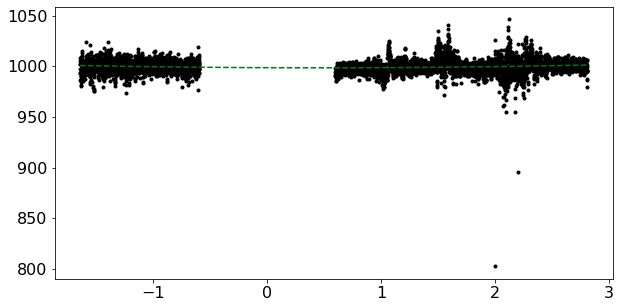

In [374]:
plt.figure(figsize=(10, 5))
plt.plot((data2_fold*24)[~oot_mask2], data2['flux'][~oot_mask2] - mean, ".k")
plt.plot((data3_fold*24)[~oot_mask3], data3['flux'][~oot_mask3] - mean, ".k")
plt.plot((data4_fold*24)[~oot_mask4], data4['flux'][~oot_mask4] - mean, ".k")
plt.plot((data5_fold*24)[~oot_mask5], data5['flux'][~oot_mask5] - mean, ".k")
x_plot = np.linspace(np.min(x_oot), np.max(x_oot), 1000)
plt.plot(x_plot, pol(x_plot), color="C1", label="model", linestyle="--")
#plt.savefig('ajuste_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')

In [375]:
x_conc = np.concatenate((data2_fold*24, data3_fold*24, data4_fold*24, data5_fold*24), axis=None)
y_conc = np.concatenate(((np.asarray(data2['flux']-mean)/pol(data2_fold*24)-1)*1e3, (np.asarray(data3['flux']-mean)/pol(data3_fold*24)-1)*1e3, 
                        (np.asarray(data4['flux']-mean)/pol(data4_fold*24)-1)*1e3, (np.asarray(data5['flux']-mean)/pol(data5_fold*24)-1)*1e3), axis=None)

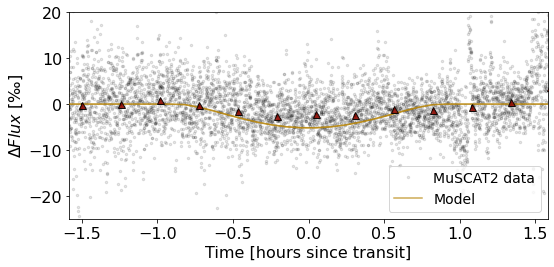

In [376]:
from scipy import stats
# Plot the folded data
plt.figure(figsize=(8,4))
plt.plot(x_conc, y_conc, '.k', ms=5, label='MuSCAT2 data', zorder=-1000, alpha=0.1)
# Plot the model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc*24, pred[1], color="C4", label="Model", alpha=0.7, zorder=1000)
plt.fill_between(phase_lc*24, pred[0], pred[2], color="C4", alpha=0.5)
# Plot the binned lightcurve
#bins = np.linspace(-0.066*24, 0.116*24, 32)
bins = np.linspace(-0.068*24, 0.0720*24, 14)
denom, _ = np.histogram(x_conc, bins)
num, _ = np.histogram(x_conc, bins, weights=y_conc)
denom[num == 0] = 1.0
binned = stats.binned_statistic(x_conc, y_conc, statistic='std', bins=bins)
binned_count = stats.binned_statistic(x_conc, y_conc, statistic='count', bins=bins)
plt.errorbar((0.5 * (bins[1:] + bins[:-1])), num / denom, yerr=binned.statistic/np.sqrt(binned_count[0]), fmt='^', color='k', 
         ms=7, markeredgecolor='k', markerfacecolor='C2', markeredgewidth=1, alpha=0.9, zorder=1100)
#plt.legend(fontsize=14, loc='best')
plt.legend(fontsize=14, loc=4)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time [hours since transit]")
plt.xlim(-0.066*24, 0.066*24)
#plt.xlim(-0.10*24, 0.10*24)
plt.ylim(-25,20)
#plt.savefig('new_phot_1273_muscat2.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.tight_layout()
plt.show()

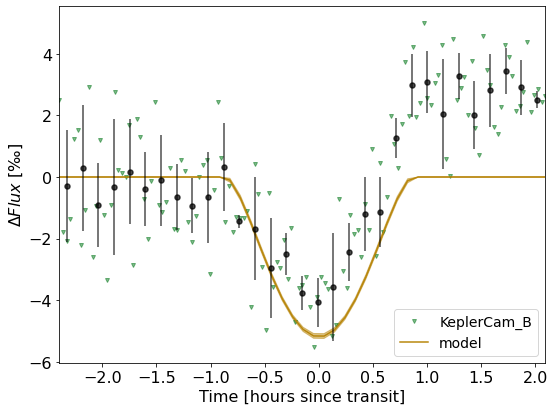

In [377]:
plt.figure(figsize=(8,6))
plt.plot(data1_fold*24, data1['flux'] - mean-1e3, "v", color='C1', ms=4, label='KeplerCam_B', alpha=0.5)
# Plot the model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc*24, pred[1], color="C4", label="model")
plt.fill_between(phase_lc*24, pred[0], pred[2], color="C4", alpha=0.5)
# Plot the binned lightcurve
bins = np.linspace(-0.10*24, 0.087*24, 32)
denom, _ = np.histogram(data1_fold*24, bins)
num, _ = np.histogram(data1_fold*24, bins, weights=data1['flux'] - mean-1e3)
denom[num == 0] = 1.0
binned = stats.binned_statistic(data1_fold*24, data1['flux']-mean-1e3, statistic='std', bins=bins)
plt.errorbar((0.5 * (bins[1:] + bins[:-1])), num / denom, yerr=binned.statistic, fmt='o', color='k', 
         ms=5, markeredgecolor='k', markeredgewidth=1.5, alpha=0.7, zorder=1000)
plt.legend(fontsize=14, loc=4)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time [hours since transit]")
plt.xlim(-0.10*24, 0.087*24)
#plt.ylim(-35,30)
#plt.savefig('new_phot_1273.png',dpi=200,bbox_inches='tight', facecolor='white')
plt.tight_layout()
plt.show()

In [378]:
# ajustemos un pol grado 2 a los datos oot
# mascaras para sacar los datos en transito
oot_mask1 = bls.transit_mask(data1['time'], p_, bls_duration, t0_)

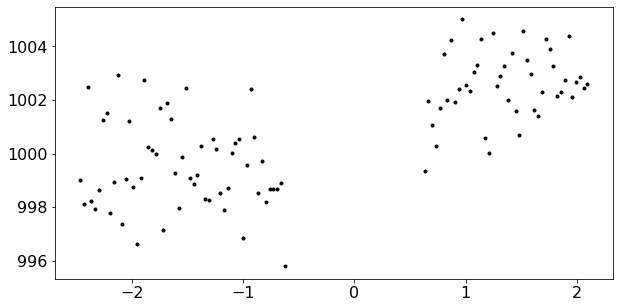

In [379]:
# checking the oot mask
plt.figure(figsize=(10, 5))
plt.plot((data1_fold*24)[~oot_mask1], data1['flux'][~oot_mask1] - mean, ".k", label="data1", zorder=-1000)

In [380]:
# fitemos un pol grado 2 a los datos oot
x_oot1 = data1_fold[~oot_mask1]*24
y_oot1 = data1['flux'][~oot_mask1]
# saco los outliers con criterio de 3 sigma
sigmas = 3
index2 = (y_oot1 >= np.mean(y_oot1)-sigmas*np.std(y_oot1)) & (y_oot1 <= np.mean(y_oot1)+sigmas*np.std(y_oot1))
y_oot = y_oot1[index2]
x_oot = x_oot1[index2]
z = np.polyfit(x_oot, y_oot, 2) 
def pol(x):
    return np.asarray(z[0]*x**2 + z[1]*x + z[2])

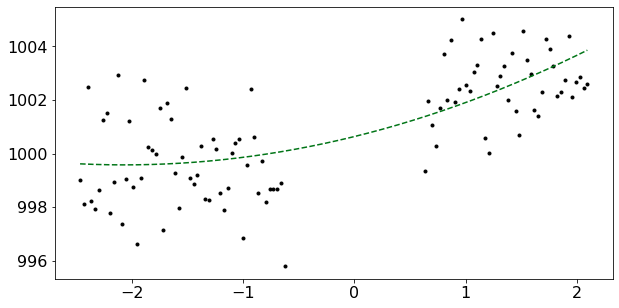

In [381]:
plt.figure(figsize=(10, 5))
plt.plot(x_oot, y_oot - mean, ".k", label="data1", zorder=-1000)
x_plot = np.linspace(np.min(x_oot), np.max(x_oot), 1000)
plt.plot(x_plot, pol(x_plot), color="C1", label="model", linestyle="--")
plt.show()

In [382]:
y_conc2 = (np.asarray(data1['flux']-mean)/pol(data1_fold*24)-1)*1e3

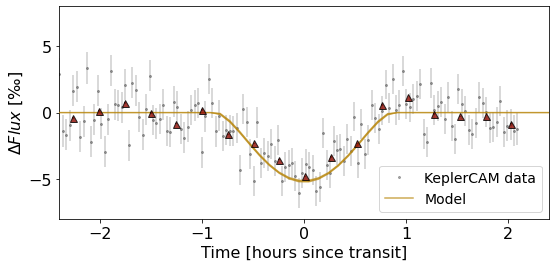

In [393]:
plt.figure(figsize=(8,4))
# plt.plot(data1_fold*24, (np.asarray(data1['flux']-mean)/pol(data1_fold*24)-1)*1e3, '.k', zorder=-1000, label='KeplerCAM data', alpha=0.3)
plt.plot(data1_fold*24, y_conc2, '.', color='k', ms=4, zorder=-1000, label='KeplerCAM data', alpha=0.3)
plt.errorbar(data1_fold*24, y_conc2, yerr=data1['flux_err'], fmt='none', color='k', ms=4, zorder=-1000, alpha=0.2)
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc*24, pred[1], color="C4", label="Model", alpha=0.7, zorder=1000)
plt.fill_between(phase_lc*24, pred[0], pred[2], color="C4", alpha=0.5, zorder=1000)
# Plot the binned lightcurve
#bins = np.linspace(-0.10*24, 0.087*24, 25)
bins = np.linspace(-0.11*24, 0.09*24, 20)
denom, _ = np.histogram(data1_fold*24, bins)
num, _ = np.histogram(data1_fold*24, bins, weights=y_conc2)
denom[num == 0] = 1.0
binned = stats.binned_statistic(data1_fold*24, (np.asarray(data1['flux']-mean)/pol(data1_fold*24)-1)*1e3, statistic='std', bins=bins)
binned_count = stats.binned_statistic(data1_fold*24, (np.asarray(data1['flux']-mean)/pol(data1_fold*24)-1)*1e3, statistic='count', bins=bins)
plt.errorbar((0.5 * (bins[1:] + bins[:-1])), num / denom, yerr=binned.statistic/np.sqrt(binned_count[0]*100), fmt='^', color='k', 
                ms=7, markeredgecolor='k', elinewidth=1.5, markerfacecolor='C2', markeredgewidth=1, alpha=0.8, zorder=1100)
#plt.ylim(-10,10)
plt.legend(fontsize=14, loc=4)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time [hours since transit]")
plt.ylim(-8,8)
plt.xlim(-0.10*24, 0.10*24)
plt.tight_layout()
#plt.savefig('new_phot_1273_keplercam.png',dpi=300,bbox_inches='tight', facecolor='white')
